## Question: "How do plan rates and benefits vary across states?"

In [1]:
import sys
import copy
import matplotlib.pyplot as plt

sys.path.append("..") # Make root modules available to this script

from classes.sqliteTableExplorer import SqliteTableExplorer

# Use class to connect and create a cursor for querying the database
sqlite_table_explorer = SqliteTableExplorer()

'Rate' table plan rate information but we can also see that it has state infomation (IndividualRate) so dont need to join with another table to answer this question, only this will be enough

In [2]:
table = "Rate"
print(f"----{table}----", *sqlite_table_explorer.get_table_col_types(table), sep="\n")

----Rate----
('BusinessYear', 'INTEGER')
('StateCode', 'TEXT')
('IssuerId', 'INTEGER')
('SourceName', 'TEXT')
('VersionNum', 'INTEGER')
('ImportDate', 'TEXT')
('IssuerId2', 'INTEGER')
('FederalTIN', 'TEXT')
('RateEffectiveDate', 'TEXT')
('RateExpirationDate', 'TEXT')
('PlanId', 'TEXT')
('RatingAreaId', 'TEXT')
('Tobacco', 'TEXT')
('Age', 'TEXT')
('IndividualRate', 'NUMERIC')
('IndividualTobaccoRate', 'NUMERIC')
('Couple', 'NUMERIC')
('PrimarySubscriberAndOneDependent', 'NUMERIC')
('PrimarySubscriberAndTwoDependents', 'NUMERIC')
('PrimarySubscriberAndThreeOrMoreDependents', 'NUMERIC')
('CoupleAndOneDependent', 'NUMERIC')
('CoupleAndTwoDependents', 'NUMERIC')
('CoupleAndThreeOrMoreDependents', 'NUMERIC')
('RowNumber', 'INTEGER')


Looking at the columns the ones we will need are "IndividualRate" and "StateCode", this is important since full disc scan can be very slow using sqlite3, but getting specific columns if fast.

In [3]:
Rate = sqlite_table_explorer.read("Rate",["StateCode", "IndividualRate"])

count    1.269444e+07
mean     4.098026e+03
std      6.122271e+04
min      0.000000e+00
25%      2.933000e+01
50%      2.916000e+02
75%      4.789800e+02
max      9.999990e+05
Name: IndividualRate, dtype: float64


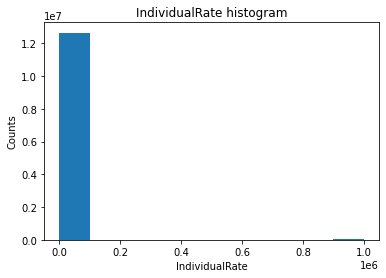

In [4]:
fig, ax = plt.subplots(1, 1) 
plt.hist(Rate["IndividualRate"])
ax.set_title("IndividualRate histogram")
ax.set_xlabel("IndividualRate")
ax.set_ylabel("Counts")
print(Rate["IndividualRate"].describe())
plt.show()

We see from the summary statistics that 75% of the data are less than 5000 so lets create 2 bins (split on value 5000) and zoom in the data to see them.

In [5]:
rate_copy = copy.copy(Rate) #make a shallow copy so we dont touch the original data
rate_copy.loc[rate_copy["IndividualRate"]>=5000,"IndividualRate"].value_counts()

IndividualRate
999999.00    47790
9999.00      23580
9999.99       1080
5079.20          4
5254.85          4
5006.03          4
5017.40          4
5112.26          4
5170.77          2
5032.40          2
5030.47          2
5220.50          2
5046.02          2
5078.84          2
5503.85          2
5259.14          2
5319.89          2
5243.24          2
5255.15          2
5224.10          2
5116.43          2
5354.51          2
5204.78          2
5053.07          2
5083.37          2
5021.51          2
5010.11          2
5136.98          1
5415.80          1
5270.86          1
5155.28          1
5140.51          1
5002.95          1
5021.29          1
5159.36          1
5171.09          1
5094.69          1
5234.78          1
5032.71          1
5175.00          1
5036.51          1
5268.84          1
5127.84          1
5121.52          1
5015.40          1
5002.04          1
5034.58          1
Name: count, dtype: int64

Aha! We see that for IndividualRates >= 6000 theres a concentration around 3 numbers and they appear a lot of times but these values seem to be out of place, since theres no other values around them, so we can label them as outliers or they may have a special meaning to the authors.
For the rest of the analysis we will focus on IndividualRate values < 6000.

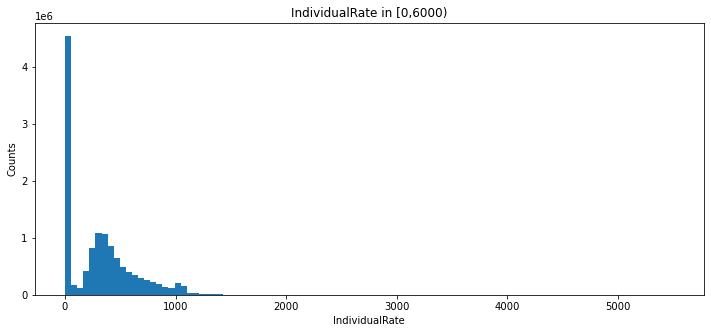

In [6]:
rate_copy = rate_copy.loc[rate_copy["IndividualRate"]<6000,]
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Let's use bins=100 so we get 100 values in each bin.
ax.hist(rate_copy["IndividualRate"], bins = 100)
ax.set_title("IndividualRate in [0,6000)")
ax.set_xlabel("IndividualRate")
ax.set_ylabel("Counts")

plt.show()

We see that there's a lot of values having 0 rate and then the data follows a right skewed distribution which means most rates sold exist in the lower price range and the more expensive it gets, the less people choose it.

(0.0, 2000.0)

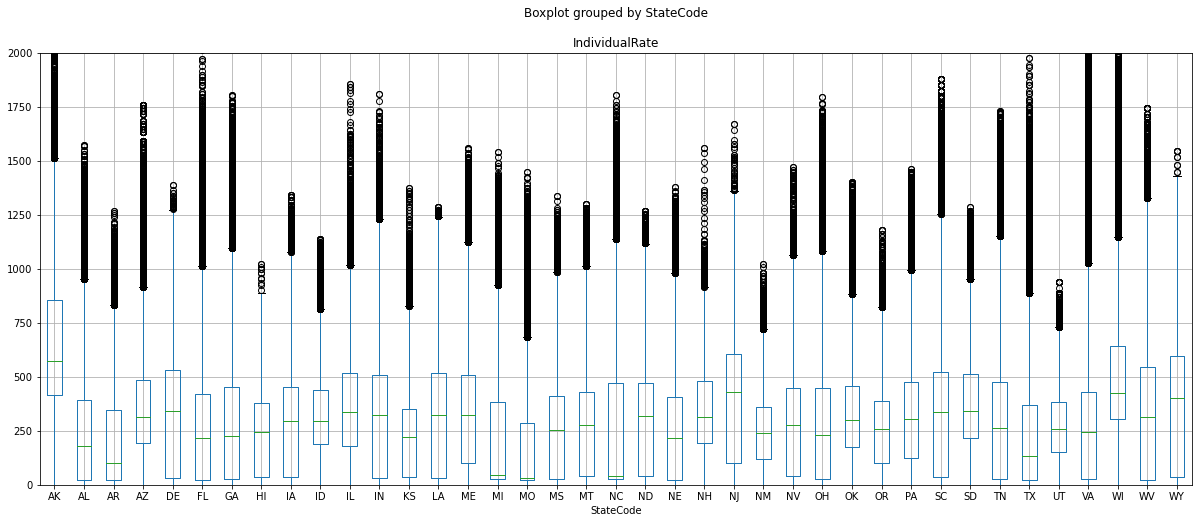

In [7]:
rate_index = rate_copy.index
ax2 = rate_copy.boxplot(by= "StateCode", column ="IndividualRate", figsize = (20, 8)) #, title="IndividualRate per country")
ax2.set_ylim([0,2000])

We see that for most countries most of their data lie in the range (0,500) and the median value ~250.

From this plot we can also confirm the right swered previous plot as most values are located in the lower range with the higher ones been seen as outliers for values greater than 1000. From their density we can assume that this is a different class of high value rates and few people choose it.

The countries having the most expensive rates overall (>5000) are 
* Alaska (AK)
* Virginia (VA)
* Wisconsin (WI)

Some of the highest on average rates are:
* Alaska (AK) with most values around (400, 800) range with median > 500.
* Wisconsin (WI) with most values around (300, 600) range with median ~ 300.
* Virginia (VA) seem to have the highest maximum rates across all countries with WI, AK having also some of the highest mean rates.

Some of the lowest on average rates are:
*  Missouri (MO) with most values around (0, 300) range with median < 100.
*  Michigan (MI) with most values around (0, 400) range with median < 100.
*  North Carolina (NC) with most values around (0, 500) range with median < 100.